In [1]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../src')

from dataset import DatasetConfig, DatasetBuilder
from geometry import Rays
import os
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from collections import defaultdict
from typing import Callable, Dict, List, Tuple
%matplotlib inline

plt.rcParams["figure.figsize"] = (12, 12)

In [2]:
ds_config =  DatasetConfig(model_dir='../dataset/pinecone/sparse/0/',
                           images_dir='../dataset/pinecone/images/',
                           batch_from_single_image=True,
                           batch_size=64)
dataset_builder = DatasetBuilder(ds_config)
train_ds = dataset_builder.build_train_dataset()

In [3]:
rays = []

for elements in train_ds.take(1).as_numpy_iterator():
    rays.append(elements)

In [186]:
def positional_encoding(x: jnp.ndarray, min_deg: int, max_deg: int):
    if min_deg == max_deg:
        return x
    scales = jnp.array([2**i for i in range(min_deg, max_deg)])
    xb = jnp.reshape(x[..., jnp.newaxis] * scales, [x.shape[0], x.shape[1], -1])
    four_feat = jnp.sin(jnp.concatenate([xb, xb + 0.5 * jnp.pi], axis=-1))
    return jnp.concatenate([x] + [four_feat], axis=-1)

points = jnp.ones((batches, num_samples, 3))
posi_encode = positional_encoding(points, 0, 10)
print(posi_encode.shape)

(8, 1000, 63)


In [166]:
def volumetric_rendering(points_rgb, points_sigma, points_z, dirs, white_bkgd=True):
    dists = points_z[..., 1:] - points_z[..., :-1]
    dists = jnp.concatenate([dists, 1e10 * jnp.ones_like(dists[..., :1])], axis=-1)
    dists = dists * jnp.linalg.norm(dirs, axis=-1)

    dists_sigma = points_sigma * dists
    alpha = 1.0 - jnp.exp(-dists_sigma)

    transmit = jnp.exp(-jnp.cumsum(dists_sigma[..., :-1], axis=-1))
    transmit = jnp.concatenate([jnp.ones_like(transmit[..., :1]), transmit], axis=-1)
    weights = alpha * transmit

    rgb = jnp.sum(weights[..., jnp.newaxis] * points_rgb, axis=-2)
    depth = jnp.sum(weights * points_z, axis=-1)
    acc = jnp.sum(weights, axis=-1)
    disp = acc / (depth + 1e-5)
    if white_bkgd:
        rgb = rgb + (1. - acc[..., jnp.newaxis])
    return rgb, disp, acc, weights

batches = 8
num_samples = 1000
points_rgb = jnp.ones((batches, num_samples, 3))
dirs = jnp.ones((batches, num_samples, 3))

near = 1
far = 100
z_values = jnp.linspace(near, far, num_samples)
z_values = jnp.broadcast_to(z_values, (batches, num_samples))

points_sigma = jnp.exp(-0.5 * jnp.square((z_values - 50) / 1.0))

rgb, disp, acc, weights = volumetric_rendering(points_rgb, points_sigma, z_values, dirs)

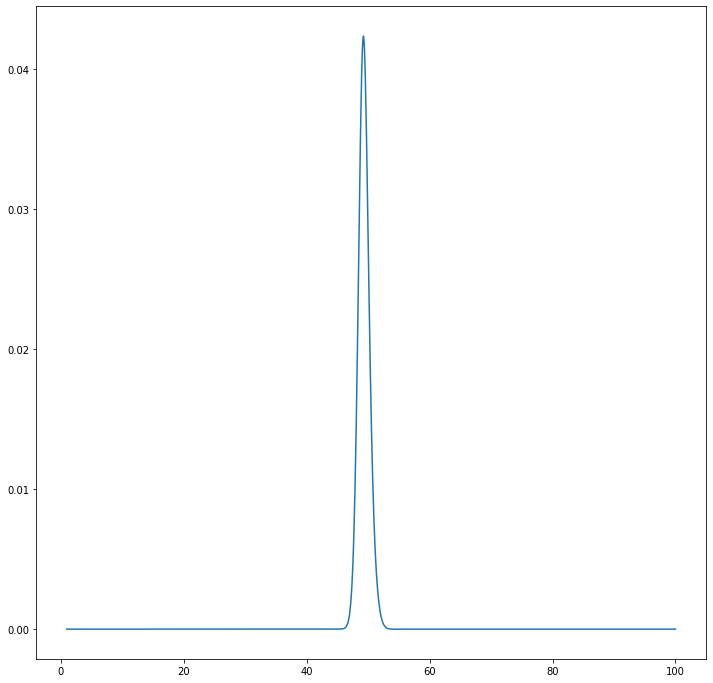

In [159]:
plt.plot(z_values[0, ...], weights[0, ...])

(-49.95, 1048.95, -19.991476440429448, 419.8210052490234)

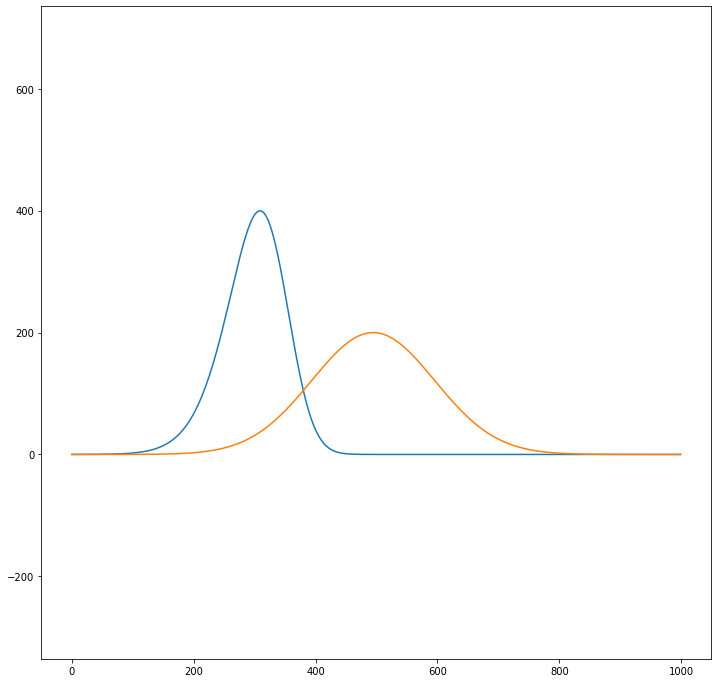

In [90]:
plt.plot(weights[0, ...] * 50000)
plt.plot(points_sigma[0, ...] * 200)
plt.axis("equal")

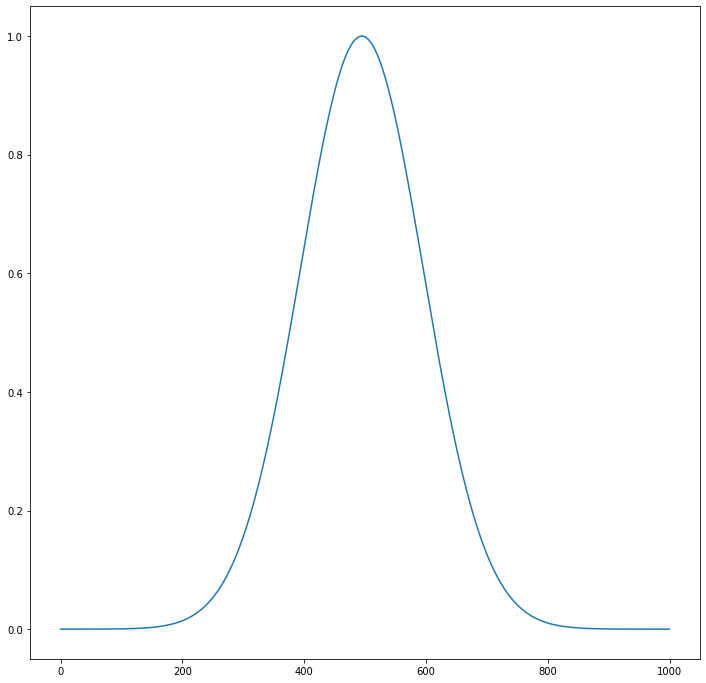

In [51]:
plt.plot(points_sigma[0, ...])

In [8]:
from nerf_utils import sample_along_rays
import jax.numpy as jnp
from jax import random, vmap, jit
import functools

rays = Rays(elements[0], elements[1], elements[2])

num_rays = rays.origins.shape[0]
num_samples = 5000

num_bins = 1000

near = 1
far = 100

bins = jnp.linspace(near, far, num_bins)
get_weights = lambda m: jnp.exp(-0.5 * jnp.square((bins - m) / 2)) + jnp.exp(-0.5 * jnp.square((bins - m - 10) / 5))
centers = jnp.linspace(20, 80, num_rays, dtype=jnp.float32)[::-1]
weights = vmap(get_weights)(centers)
bins = jnp.broadcast_to(bins, (num_rays, num_bins))

sampler_fn = jit(functools.partial(sample_along_rays,
                                   num_samples=num_samples,
                                   randomized=True))
key = random.PRNGKey(0)
points, z_values = sampler_fn(key, rays, bins, weights)

Text(0.5, 1.0, 'Sampled Distribution')

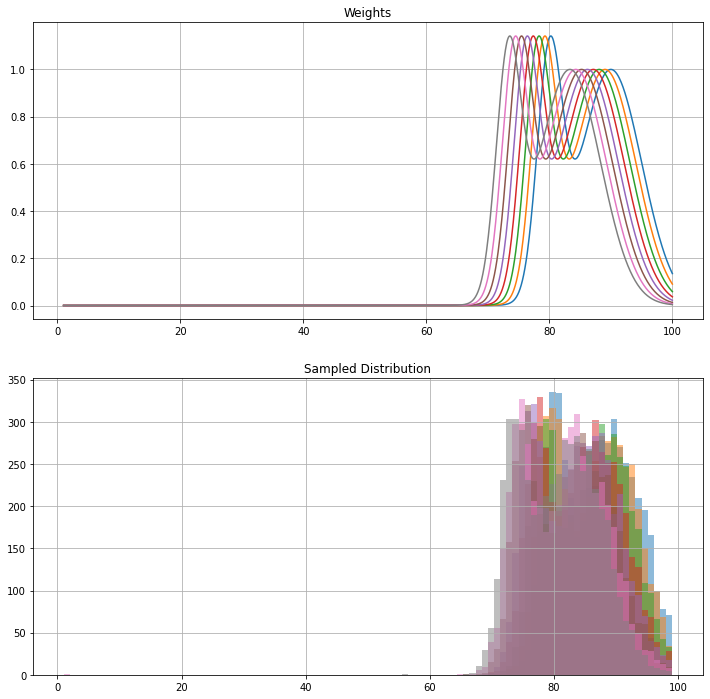

In [12]:
ax = plt.subplot(211)
for i in range(8):
    ax.plot(bins[i], weights[i])
ax.grid("on")
ax.set_title("Weights")

ax = plt.subplot(212)
for i in range(8):
    _ = ax.hist(jnp.linalg.norm(points[i] - rays.origins[i], axis=-1), bins[i][::10], alpha=0.5)
ax.grid("on")
ax.set_title("Sampled Distribution")

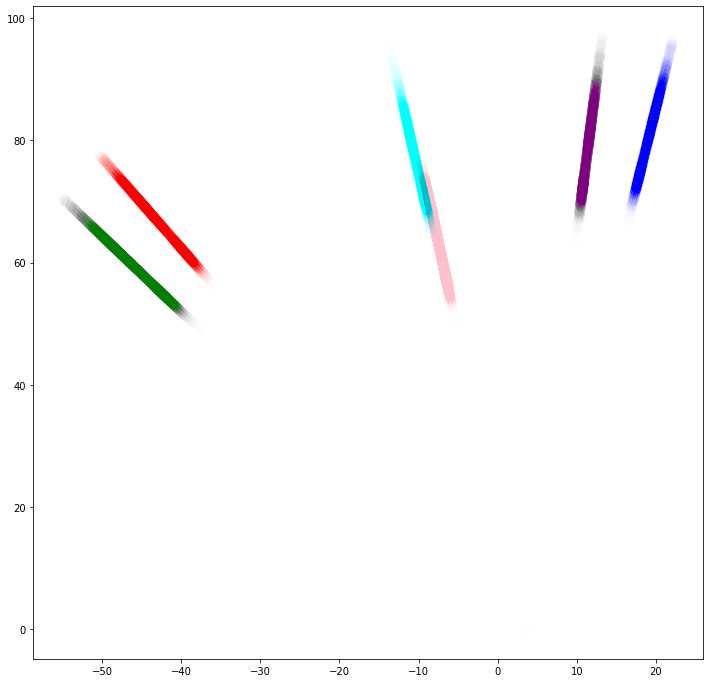

In [13]:
alpha=0.005

i = 0
x = points[i, ..., 0]
y = points[i, ..., 1]
z = points[i, ..., 2]
plt.scatter(x, z, s=100, color="red", alpha=alpha)

i = 2
x = points[i, ..., 0]
y = points[i, ..., 1]
z = points[i, ..., 2]
plt.scatter(x, z, s=100, color="green", alpha=alpha)

i = 3
x = points[i, ..., 0]
y = points[i, ..., 1]
z = points[i, ..., 2]
plt.scatter(x, z, s=100, color="blue", alpha=alpha)

i = 5
x = points[i, ..., 0]
y = points[i, ..., 1]
z = points[i, ..., 2]
plt.scatter(x, z, s=100, color="pink", alpha=alpha)

i = 6
x = points[i, ..., 0]
y = points[i, ..., 1]
z = points[i, ..., 2]
plt.scatter(x, z, s=100, color="purple", alpha=alpha)

i = 7
x = points[i, ..., 0]
y = points[i, ..., 1]
z = points[i, ..., 2]
plt.scatter(x, z, s=100, color="cyan", alpha=alpha)

In [854]:
views = jnp.broadcast_to(rays.directions[:, jnp.newaxis, :], points.shape)
views.shape

(8, 5000, 3)

In [858]:
views[0]

(5000, 3)

In [857]:
rays.directions

array([[ 0.35822025, -0.07059386,  0.9309573 ],
       [ 0.479604  , -0.13443677,  0.8671186 ],
       [-0.13947505, -0.10665706,  0.9844559 ],
       [ 0.20156561, -0.5644826 ,  0.80044574],
       [ 0.35279506,  0.04662992,  0.9345315 ],
       [-0.00354181, -0.07558354,  0.99712485],
       [-0.11103202,  0.05490232,  0.99229115],
       [-0.12393689, -0.13990475,  0.9823688 ]], dtype=float32)

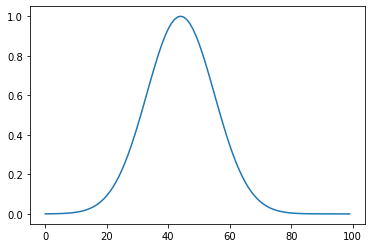

In [174]:
plt.plot(weights)

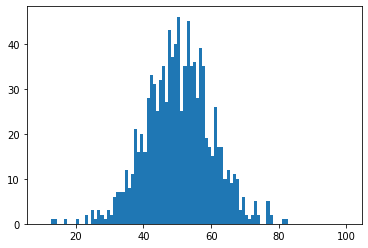

In [188]:
_ = plt.hist(z_samples, bins)